In [2]:
import io
#npx degit jghawaly/CSC7809_FoundationModels/Project2/data/raw raw/                             
import os, glob
from typing import Tuple
import numpy as np
import torch
import numpy as np
from functools import reduce
import sentencepiece as spm
import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW, lr_scheduler
from torcheval.metrics.metric import Metric
from torcheval.metrics.text import Perplexity, BLEUScore
import json
from tqdm import tqdm
from datetime import datetime
from word_prediction import TokenizedDataset, read_jsonl, add_special_token, training_kit
from models import LSTM


In [3]:
tokenizer_location = "bptokenizer.model"
training_data = read_jsonl('./data/train.jsonl')
testing_data = read_jsonl('./data/test.jsonl')
sp = spm.SentencePieceProcessor(tokenizer_location)

hidden_size = 512  # Number of hidden units
output_size = sp.GetPieceSize() # Output dimension
seq_len = 30  # Length of the input sequence
batch_size = 256  # Number of sequences in a batch
embed_dim = 1024

In [4]:
def read_jsonl(pat):
    with open(pat, 'r') as f:
        data = [json.loads(line) for line in f]
    return data
def add_special_token(prompt, completion):
    # If the beginning of the prompt is upper case, then we assume it is the start of a sequence
    if prompt[0].isupper():
        prompt = '<bos>' + prompt
    # If the end of the completion is a terminating punctuation, then we assume it is the end of a sequence
    if completion.endswith('.') or completion.endswith('?') or completion.endswith('!'):
        completion += '<eos>'
    return  prompt, completion
    
def mkcollation(pad_id):
    def collate(batch):
        input_batch, target_batch = zip(*batch)
        input_batch = torch.nn.utils.rnn.pad_sequence(input_batch, batch_first=True, padding_value=pad_id)
        target_batch = torch.nn.utils.rnn.pad_sequence(target_batch, batch_first=True, padding_value=pad_id)
        return input_batch, target_batch
    return collate

def evaluate_perplexity(model, perplexity_metric, data_loader, device):
    hidden = model.init_hidden(model.batch_size)
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Initialize hidden state for this batch
            # Forward pass through the model
            logits, hidden = model(inputs, hidden)
            perplexity_metric.update(logits, labels)
            #print(perplexity_metric.compute().item())
    
    # Compute perplexity: torcheval.Perplexity returns exp(avg_loss)
    ppl = perplexity_metric.compute().item()
    return ppl



if torch.cuda.is_available():
    print('torch cuda is_available')
    device = torch.device('cuda')          # Use GPU
else:
    print('torch cuda not is_available')
    device = torch.device('cpu')           # Use CPU
    
metrics = {
    'perp': Perplexity(ignore_index=sp.pad_id()).to(device),
    'bleu': BLEUScore(n_gram=3).to(device)
}


torch cuda is_available


In [5]:
collation = mkcollation(sp.pad_id())
 
training_loader = DataLoader(
    TokenizedDataset(training_data, sp, seq_len),
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,

    collate_fn=collation
) 
valset, testset = torch.utils.data.random_split(TokenizedDataset(testing_data, sp, seq_len), [.8, .2])
validation_loader = DataLoader(
    valset,
    drop_last=True,
    shuffle=False,
    batch_size=batch_size,
    collate_fn=collation
)

test_loader = DataLoader(
    testset,
    shuffle=False,
    drop_last=True,
    batch_size=batch_size,
    collate_fn=collation
)


In [6]:
lstmmodel = LSTM(embed_dim=embed_dim,
                 hidden_size=hidden_size,
                 output_size=output_size,
                 batch_size=batch_size,
                 n_layers=4,
                 device=device,
                 tokenizer=sp,
                 name="lstm").to(device)
trainkit = training_kit(params=lstmmodel.parameters(),
                        lr=0.001,
                        weight_decay=0.01,
                        epochs=30,
                        dataloader=training_loader,
                        valloader=validation_loader,
                        batch_size=batch_size)

In [7]:
lstmtraining_loss, lstmvalidation_loss = lstmmodel.reps(trainkit)

  3%|████▊                                                                                                                                             | 1/30 [00:22<11:04, 22.92s/it]

numbers = (avg loss 6.8180076301871955 avgval 6.786834160486857 bestval 1000000.0)
patience reset


  7%|█████████▋                                                                                                                                        | 2/30 [00:45<10:41, 22.90s/it]

numbers = (avg loss 6.71708133313563 avgval 6.78142237663269 bestval 6.786834160486857)
patience reset


 10%|██████████████▌                                                                                                                                   | 3/30 [01:08<10:19, 22.96s/it]

numbers = (avg loss 6.710321342790282 avgval 6.7734619299570715 bestval 6.78142237663269)
patience reset


 13%|███████████████████▍                                                                                                                              | 4/30 [01:32<10:00, 23.08s/it]

numbers = (avg loss 6.700986047843834 avgval 6.763899660110473 bestval 6.7734619299570715)
patience reset


 17%|████████████████████████▎                                                                                                                         | 5/30 [01:55<09:38, 23.14s/it]

numbers = (avg loss 6.689719330180775 avgval 6.750768756866455 bestval 6.763899660110473)
patience reset


 20%|█████████████████████████████▏                                                                                                                    | 6/30 [02:18<09:17, 23.23s/it]

numbers = (avg loss 6.682543042418245 avgval 6.744622643788656 bestval 6.750768756866455)
patience reset


 23%|██████████████████████████████████                                                                                                                | 7/30 [02:42<08:55, 23.30s/it]

numbers = (avg loss 6.662702774072622 avgval 6.618590132395426 bestval 6.744622643788656)
patience reset


 27%|██████████████████████████████████████▉                                                                                                           | 8/30 [03:05<08:34, 23.40s/it]

numbers = (avg loss 6.307227323581646 avgval 6.134583155314128 bestval 6.618590132395426)
patience reset


 30%|███████████████████████████████████████████▊                                                                                                      | 9/30 [03:29<08:14, 23.55s/it]

numbers = (avg loss 5.779208632258626 avgval 5.71308757464091 bestval 6.134583155314128)
patience reset


 33%|████████████████████████████████████████████████▎                                                                                                | 10/30 [03:53<07:54, 23.72s/it]

numbers = (avg loss 5.482406334443525 avgval 5.543289852142334 bestval 5.71308757464091)
patience reset


 37%|█████████████████████████████████████████████████████▏                                                                                           | 11/30 [04:17<07:33, 23.86s/it]

numbers = (avg loss 5.311215313998136 avgval 5.433718379338583 bestval 5.543289852142334)
patience reset


 40%|██████████████████████████████████████████████████████████                                                                                       | 12/30 [04:42<07:11, 23.99s/it]

numbers = (avg loss 5.188981003575511 avgval 5.362323156992594 bestval 5.433718379338583)
patience reset


 43%|██████████████████████████████████████████████████████████████▊                                                                                  | 13/30 [05:06<06:50, 24.12s/it]

numbers = (avg loss 5.093089602210305 avgval 5.3091869672139484 bestval 5.362323156992594)
patience reset


 47%|███████████████████████████████████████████████████████████████████▋                                                                             | 14/30 [05:31<06:27, 24.23s/it]

numbers = (avg loss 5.015113437330568 avgval 5.268879302342733 bestval 5.3091869672139484)
patience reset


 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 15/30 [05:55<06:04, 24.32s/it]

numbers = (avg loss 4.949383738753084 avgval 5.239543692270915 bestval 5.268879302342733)
patience reset


 53%|█████████████████████████████████████████████████████████████████████████████▎                                                                   | 16/30 [06:20<05:41, 24.41s/it]

numbers = (avg loss 4.890209191805356 avgval 5.21328166325887 bestval 5.239543692270915)
patience reset


 57%|██████████████████████████████████████████████████████████████████████████████████▏                                                              | 17/30 [06:45<05:18, 24.51s/it]

numbers = (avg loss 4.836702510908053 avgval 5.1928744157155355 bestval 5.21328166325887)
patience reset


 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 18/30 [07:10<04:56, 24.75s/it]

numbers = (avg loss 4.787595395918016 avgval 5.173384650548299 bestval 5.1928744157155355)
patience reset


 63%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 19/30 [07:35<04:33, 24.91s/it]

numbers = (avg loss 4.742383690623494 avgval 5.1612637360890705 bestval 5.173384650548299)
patience reset


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 20/30 [08:01<04:10, 25.08s/it]

numbers = (avg loss 4.700593257879282 avgval 5.15064860979716 bestval 5.1612637360890705)
patience reset


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 21/30 [08:26<03:46, 25.21s/it]

numbers = (avg loss 4.661312360268135 avgval 5.135677099227905 bestval 5.15064860979716)
patience reset


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 22/30 [08:52<03:22, 25.31s/it]

numbers = (avg loss 4.62128311008602 avgval 5.129370816548666 bestval 5.135677099227905)
patience reset


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 23/30 [09:17<02:57, 25.38s/it]

numbers = (avg loss 4.58715592731129 avgval 5.12320343653361 bestval 5.129370816548666)
patience reset


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 24/30 [09:43<02:32, 25.38s/it]

numbers = (avg loss 4.552369994002503 avgval 5.115924612681071 bestval 5.12320343653361)
patience reset


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 25/30 [10:08<02:07, 25.41s/it]

numbers = (avg loss 4.52001472262593 avgval 5.11133041381836 bestval 5.115924612681071)
patience reset


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 26/30 [10:34<01:41, 25.44s/it]

numbers = (avg loss 4.489271442611496 avgval 5.1079559326171875 bestval 5.11133041381836)
patience reset


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 27/30 [10:59<01:16, 25.48s/it]

numbers = (avg loss 4.459011223409083 avgval 5.108677895863851 bestval 5.1079559326171875)
patience counted increased


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 28/30 [11:25<00:51, 25.53s/it]

numbers = (avg loss 4.429526264017278 avgval 5.1056175072987875 bestval 5.1079559326171875)
patience reset


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 29/30 [11:50<00:25, 25.54s/it]

numbers = (avg loss 4.401531848040494 avgval 5.1020774682362875 bestval 5.1056175072987875)
patience reset


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [12:16<00:00, 24.55s/it]

numbers = (avg loss 4.375667807343718 avgval 5.104472017288208 bestval 5.1020774682362875)
patience counted increased


In [8]:
import matplotlib as plt
import matplotlib.pyplot as plt

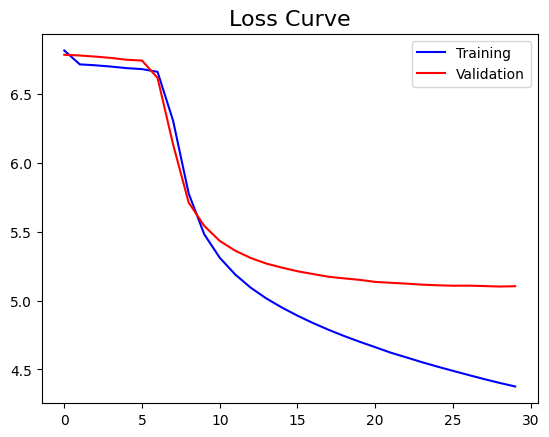

In [9]:
plt.plot(lstmtraining_loss, color='b', label='Training')
plt.plot(lstmvalidation_loss, color='r', label='Validation')
plt.title("Loss Curve", size=16)
plt.legend()

In [10]:
ppl = evaluate_perplexity(lstmmodel, metrics['perp'], test_loader, device)
print("perplexity", ppl)
#lstmmodel.load_state_dict(torch.load('./model_20250325_233555.torch'))
print(lstmmodel.prompt('The wizard of waverly place'))

. it was a great one, and the same of the most interesting and ungrailing condition of his own. he has never seen her in his own house, and said: yes, yes, said monte cristo, that i have
